In [1]:
import os
import time
import argparse
import numpy as np
import torch
from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector
import cv2
from deep_utils import Box, split_extension
from cartoonX_yolo import CartoonX
import matplotlib.pyplot as plt

/DATA/lost+found/lost/lost/anaconda3/envs/pytorch/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
!pip install -U deep-utils

In [2]:
device = 'cuda:1'
model_path='yolov5s.pt'
names=None
img_path='eagel2.jpg'
input_size = (480,480)
img = cv2.imread(img_path)
og_shape=img.shape
img=cv2.resize(img, (480,480))
print('[INFO] Loading the model')
model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size,
                                  names=None if names is None else names.strip().split(","))
torch_img = model.preprocessing(img[..., ::-1])

[INFO] Loading the model


Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients


[INFO] Model is loaded
[INFO] fetching names from coco file


torch.Size([1, 3, 480, 480])


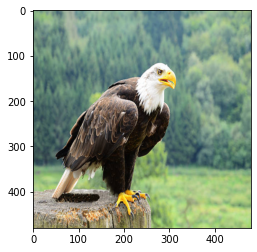

In [3]:
%matplotlib inline
plt.imshow(torch_img[0].permute(1,2,0).cpu().detach())
print(torch_img.shape)

In [4]:
og_shape

(408, 612, 3)

In [5]:
# set CartoonX hyperparameters
preds, logits,old_logits,_ = model(torch_img)
print(old_logits.shape)
target=old_logits.argmax(1,keepdim=True)
print(target.shape)
device='cuda:1'
HPARAMS ={"wave": "db3", "mode": "zero", "J": 5,
          "l1lambda": 20, "step_size": 1e-2,
          "num_steps": 200,  "batch_size": 32,
          "distortion_measure": "label","return_mask":True} 

# get Cartoon RDE 
cartoonX = CartoonX(model=model, device=device, **HPARAMS)
explanation,mask = cartoonX(torch_img, target)

torch.Size([1, 80, 14175])
torch.Size([1, 1, 14175])
 iter 199

## Visualize YOLO Explanation 

(408, 612)


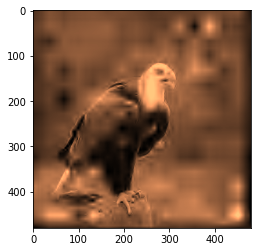

In [8]:
plt.imshow(explanation.permute(1,2,0).cpu(),cmap='copper')

img2=explanation.permute(1,2,0).cpu()[:,:,0].numpy()
zz = cv2.resize(img2, dsize=(og_shape[1], og_shape[0]), interpolation=cv2.INTER_CUBIC)
print(zz.shape)
plt.imsave('eagle_ObjectDCartoon.png', zz,cmap='copper')

In [9]:
def put_text_box(bbox, cls_name,res_img):
    x1, y1, x2, y2 = bbox
    # this is a bug in cv2. It does not put box on a converted image from torch unless it's buffered and read again!
#     cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = Box.put_box(res_img, bbox)
    res_img = Box.put_text(res_img, cls_name, (x1, y1))
    return res_img


## Visualize YOLO Detection 

(408, 612, 3)


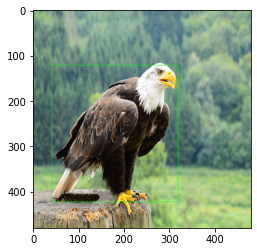

In [10]:
v=put_text_box(preds[0][0][0],"",cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(v)
zz = cv2.resize(v, dsize=(og_shape[1], og_shape[0]), interpolation=cv2.INTER_CUBIC)
print(zz.shape)
plt.imsave('eagle_ObjectD.png', zz,cmap='copper')
